<a href="https://colab.research.google.com/github/rocioavakian/RNA-VGG16/blob/master/Red_Neuronal_VGG16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **PROCESAMIENTO DE CARTAS DINAMOMÉTRICAS**





## Red Neuronal Artificial VGG16
Se utilizó una red neuronal artificial con topología VGG16 utilizando Keras con Tensorflow. VGG16 es una arquitectura de red neuronal artificial predefinida y verificada para el reconocimiento visual de imágenes, el número 16 refiere al número de capas de la misma. Es una red neuronal convolucional, es decir, es un tipo de RNA donde las neuronas corresponden a campos receptivos de una manera muy similar a las neuronas en la corteza visual primaria (V1) de un cerebro biológico. Este tipo de red es una variación de un [RNA perceptron multicapa](https://es.wikipedia.org/wiki/Perceptr%C3%B3n_multicapa), sin embargo, debido a que su aplicación es realizada en matrices bidimensionales, son muy efectivas para la clasificación y segmentación de imágenes.



### Entrenamiento
En el siguiente extracto de código se entrena la RNA VGG16 en base al set de datos de problemas en cartas dinamométricas el cual se encuentra balaceado en una estructura de carpetas presentes en Google Drive divididas en Training, Validation y Testing.

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import preprocess_input, decode_predictions
from google.colab import drive
from keras.models import Sequential, Model, load_model
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard, CSVLogger
from keras import optimizers, models
from keras.layers import Dense, Dropout, GlobalAveragePooling2D
from keras import applications
from keras import backend as K
import tensorflow as tf
import os
import math

# Hacemos la conexión con google drive ya que ahí se encuentran las imágenes balanceadas en Training, Validation y Testing para cada problemática
drive.mount("/content/gdrive", force_remount=True)
root_dir = "/content/gdrive/My Drive/DYNACARDS RED NEURONAL/Data/"
train_dir = root_dir + "Training"
val_dir = root_dir + "Validation"
test_dir = root_dir + "Testing"
           
# Seteamos el tamaño de las imágenes deseado y el batch size
WIDTH=224
HEIGHT=224
BATCH_SIZE=2


# Se genera el data set de Training en base al batchsize y el tamaño de imagen definido
print("\nTraining Data Set")
train_generator = ImageDataGenerator(preprocessing_function=preprocess_input)
train_flow = train_generator.flow_from_directory(
    train_dir,
    target_size=(HEIGHT, WIDTH),
    batch_size = BATCH_SIZE
)

# Se genera el data set de Validación en base al batchsize y el tamaño de imagen definido
print("\nValidation Data Set")
val_generator = ImageDataGenerator(preprocessing_function=preprocess_input)
val_flow = val_generator.flow_from_directory(
    val_dir,
    target_size=(HEIGHT, WIDTH),
    batch_size = BATCH_SIZE
)

# Se genera el data set de Testing en base al batchsize y el tamaño de imagen definido
print("\nTest Data Set")
test_generator = ImageDataGenerator(preprocessing_function=preprocess_input)
test_flow = test_generator.flow_from_directory(
    test_dir,
    target_size=(HEIGHT, WIDTH),
    batch_size = BATCH_SIZE
)

##########

# Se inicializa la RNA VGG16 
base_model = applications.VGG16(weights='imagenet', 
                                include_top=False, 
                                input_shape=(WIDTH, HEIGHT,3))

# Se agrega una capa al modelo base de tipo global spatial average pooling
x = base_model.output

x = GlobalAveragePooling2D()(x)

# Se agrega una capa dense con el data set de Training
x = Dense(1024, activation='relu')(x)
predictions = Dense(len(train_flow.class_indices), activation='softmax')(x)

# Se genera el modelo que va a ser entrenado
model = Model(inputs=base_model.input, outputs=predictions)

# Se entrenan las capas que fueron inicializadas de forma random
for layer in base_model.layers:
    layer.trainable = False

# Se compila el modelo
# Se determinan las métricas que se irán mostrando a medida que va entrenando y se setea su learning rate
model.compile(optimizer=optimizers.Adam(lr=0.0001), metrics=['accuracy', 'top_k_categorical_accuracy'], loss='categorical_crossentropy')


########
# Se setea la cantidad de epochs
epochs_par=8


# Se determina la ruta y se configura el almacenamiento del mejor modelo a medida que se va iterando en base al mínimo loss del set Training
top_layers_file_path="/content/gdrive/My Drive/DYNACARDS RED NEURONAL/top_layers.vgg16.h5"
csv_root="/content/gdrive/My Drive/DYNACARDS RED NEURONAL/vgg16-log.csv"
checkpoint = ModelCheckpoint(top_layers_file_path, monitor='loss', verbose=1, save_best_only=True, mode='min')
early = EarlyStopping(monitor="loss", mode="min", patience=5)
csv_logger = CSVLogger(csv_root, append=True)

# Se configura el modelo para su entrenamiento
history = model.fit_generator(train_flow, 
                              epochs=epochs_par, 
                              verbose=1,
                              validation_data=val_flow,
                              validation_steps=math.ceil(val_flow.samples/val_flow.batch_size),
                              steps_per_epoch=math.ceil(train_flow.samples/train_flow.batch_size),
                              callbacks=[checkpoint, early, csv_logger])


Mounted at /content/gdrive

Training Data Set
Found 1350 images belonging to 5 classes.

Validation Data Set
Found 450 images belonging to 5 classes.

Test Data Set
Found 421 images belonging to 5 classes.
Epoch 1/8
675/675 [==============================] - 952s 1s/step - loss: 0.7010 - acc: 0.7474 - top_k_categorical_accuracy: 1.0000 - val_loss: 0.5394 - val_acc: 0.8044 - val_top_k_categorical_accuracy: 1.0000

Epoch 00001: loss improved from inf to 0.70102, saving model to /content/gdrive/My Drive/TPS 5TO/Proyecto Final/DYNACARDS RED NEURONAL/top_layers.vgg16.h5
Epoch 2/8
675/675 [==============================] - 949s 1s/step - loss: 0.4588 - acc: 0.8193 - top_k_categorical_accuracy: 1.0000 - val_loss: 0.4850 - val_acc: 0.8067 - val_top_k_categorical_accuracy: 1.0000

Epoch 00002: loss improved from 0.70102 to 0.45885, saving model to /content/gdrive/My Drive/TPS 5TO/Proyecto Final/DYNACARDS RED NEURONAL/top_layers.vgg16.h5
Epoch 3/8
675/675 [==============================] - 955s 

Parámetros ajustados:


*   **Batch size:** Es el subset del dataset de training utilizado en una iteración.

*   **Learning rate:** Es el tamaño de steps que se van a realizar para salir de un mínimo (local). Un learning rate bajo implica más pasos y tarda más en entrenar el modelo mientras que un learning rate alto implica menos pasos y un entrenamiento en menor tiempo. Sin embargo, si el learning rate es muy bajo puede nunca progresar el modelo, mientras que si es muy alto puede causar inestabilidad y nunca converger.

*   **Epochs:** Cuántes veces se va a entrenar el modelo sobre el mismo dataset.




### Evaluación de la RNA
Una vez entrenada la red neuronal artificial y ajustada junto con el set de datos de Validation, se hace una evaluación de la red con el set de datos de Testing.


In [ ]:
import math
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import preprocess_input, decode_predictions
from google.colab import drive
from keras.models import Sequential, Model, load_model
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard, CSVLogger
from keras import optimizers, models
from keras.layers import Dense, Dropout, GlobalAveragePooling2D
from keras import applications
from keras import backend as K
import tensorflow as tf
import os

# Hacemos la conexión con google drive ya que ahí se encuentran las imágenes balanceadas en Training, Validation y Testing para cada problemática
drive.mount("/content/gdrive", force_remount=True)
root_dir = "/content/gdrive/My Drive/DYNACARDS RED NEURONAL/Data/"
test_dir_eval = root_dir + "Testing"

# Seteamos el tamaño de las imágenes deseado y el batch size
WIDTH=224
HEIGHT=224
BATCH_SIZE=2

# Se genera el data set de Testing en base al batchsize y el tamaño de imagen definido
print("\nTest Data Set")
test_generator_eval = ImageDataGenerator(preprocessing_function=preprocess_input)
test_flow_eval = test_generator_eval.flow_from_directory(
    test_dir_eval,
    target_size=(HEIGHT, WIDTH),
    batch_size = BATCH_SIZE
)

# Se determina la ruta donde se encuentra el modelo entrenado almacenado y se carga el mismo
top_layers_file_path="/content/gdrive/My Drive/DYNACARDS RED NEURONAL/top_layers.vgg16.h5"
model = tf.keras.models.load_model(top_layers_file_path)

# Se evalúa el modelo en un data generator con los problemas de Testing
loss, acc, top_5 = model.evaluate_generator(
	test_flow_eval,
	verbose=True,
	steps=math.ceil(test_flow_eval.samples/test_flow_eval.batch_size))

# Se imprimen las métricas
print(f'Loss: {loss}')
print(f'Acc: {acc}')

Mounted at /content/gdrive

Test Data Set
Found 421 images belonging to 5 classes.
211/211 [==============================] - 220s 1s/step - loss: 0.3379 - acc: 0.8694 - top_k_categorical_accuracy: 1.0000
Loss: 0.33793828976888185
Acc: 0.8693586587905884
Top 5: 1.0


### Diagnóstico de imágenes

Una vez adquirido un porcentaje de accuracy y loss de la RNA entrenada aceptable, se itera sobre todas las imágenes de la base de datos para diagnosticar la totalidad de las cartas dinamométricas. 

Se hace un post a la base de datos con el porcentaje y diagnóstico de cada carta.

In [ ]:
import math
import tensorflow as tf
import os
from keras.preprocessing import image
import numpy as np
import glob
import random
import requests
from keras.models import load_model
from google.colab import drive
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import preprocess_input, decode_predictions
from google.colab import drive
from keras.models import Sequential, Model, load_model
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard, CSVLogger
from keras import optimizers, models
from keras.layers import Dense, Dropout, GlobalAveragePooling2D
from keras import applications
from keras import backend as K

# Hacemos la conexión con google drive ya que ahí se encuentran las imágenes balanceadas en Training, Validation y Testing para cada problemática
drive.mount("/content/gdrive", force_remount=True)
root_dir = "/content/gdrive/My Drive/DYNACARDS RED NEURONAL/Data/"
train_dir = root_dir + "Training"

# Seteamos el tamaño de las imágenes deseado y el batch size           
WIDTH=224
HEIGHT=224
BATCH_SIZE=2

# Se genera el data set de Training en base al batchsize y el tamaño de imagen definido
print("\nTraining Data Set")
train_generator = ImageDataGenerator(preprocessing_function=preprocess_input)
train_flow = train_generator.flow_from_directory(
    train_dir,
    target_size=(HEIGHT, WIDTH),
    batch_size = BATCH_SIZE
)

# Se escriben en el documento vgg16-labels.txt todos los diagnósticos posibles en base a la estructura de la carpeta Training
label = [k for k,v in train_flow.class_indices.items()]
with open('/content/gdrive/My Drive/DYNACARDS RED NEURONAL/vgg16-labels.txt', 'w+') as file:
    file.write("\n".join(label))

# Se determina la ruta de la carpeta Everything donde están todas las cartas dinamométricas
everything_dir = root_dir + "Everything/*/*"

# Se levanta el modelo entrenado
top_layers_file_path="/content/gdrive/My Drive/DYNACARDS RED NEURONAL/top_layers.vgg16.h5"
model_test_2 = tf.keras.models.load_model(top_layers_file_path)

# Por cada imagen de la carpeta Everything se diagnostica con el modelo entrenado y se hace un post por pozo-carta del diagnóstico y el porcentaje
file_list = glob.glob(everything_dir)
for f in file_list:
  img_path = f
  img_name = os.path.split(os.path.basename(img_path))[1]
  well_card = img_name.split('.')[0]
  well = well_card.split(' - ')[0]
  print("Well ", well)
  card = well_card.split(' - ')[1]
  print("Card ", card)
  print("File: ", img_name)
  img_cat = os.path.split(os.path.dirname(img_path))[1]
  print("Image Category: ", img_cat)
  img = image.load_img(img_path, target_size=(224, 224))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  x = preprocess_input(x)
  preds = model_test_2.predict(x)
  top_x = 5
  top_args = preds[0].argsort()[-top_x:][::-1]
  preds_label = [label[p] for p in top_args]
  print("Top " + str(top_x) + " confidence: " + " / ".join(map(str, sorted(preds[0])[-top_x:][::-1])))
  print("Top " + str(top_x) + " labels: " + " / ".join(map(str, preds_label)))
  top_y = 1
  percentage = preds[0].argsort()[-top_y:][::-1]
  diagnose = [label[p] for p in percentage]
  print("Percentage: " + " ".join(map(str, sorted(preds[0])[-top_y:][::-1])))
  print("Diagnose: " + str(diagnose[0]))
  updatePercentage = int(float(" ".join(map(str, sorted(preds[0])[-top_y:][::-1])))*100)
  updateDiagnose = str(diagnose[0])
  print("Percentaje update: " + str(updatePercentage))
  #post a la base
  #...

continue

### Análisis de Diagnósticos
En base a los resultados de diagnósticos arrojados por la Red Neuronal Artificial, se pueden analizar los siguientes casos:


**1.   Pozo 147 - Carta 662**
*   Imagen input:
  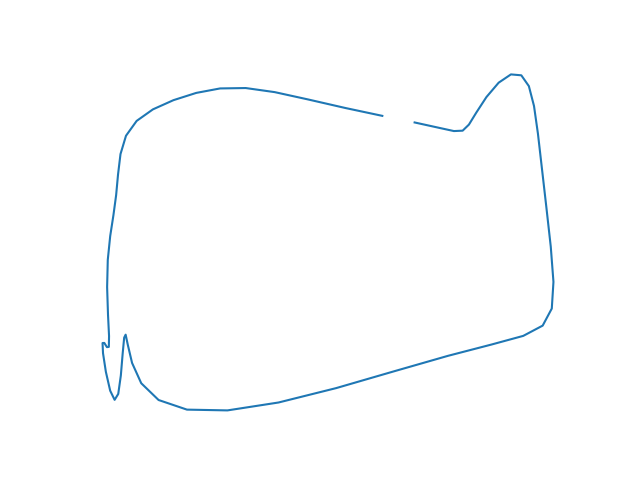

*   Output RNA:

  ```
Well  143
Card  662
File:  143 - 662.png
Image Category:  Golpe de bomba - Interferencia de gas
Top 5 confidence: 0.99993813 / 2.8402563e-05 / 2.0770287e-05 / 1.1916742e-05 / 8.3242145e-07
Top 5 labels: Golpe de bomba - Interferencia de gas / Problema no identificado / Golpe de bomba / Interferencia de gas / Sin problemas
Percentage: 0.99993813
Diagnose: Golpe de bomba - Interferencia de gas
Percentaje update: 99
```
*   Análisis:
  Con un 99% de porcentaje de exactitud, podemos apreciar el correcto diagnóstico de la RNA debido a la curva en el extremo inferior izquierdo que posee la imagen, concluyendo que se trata de una problemática de golpe de bomba.
 
**2.   Pozo 147 - Carta 481**
*   Imagen input:

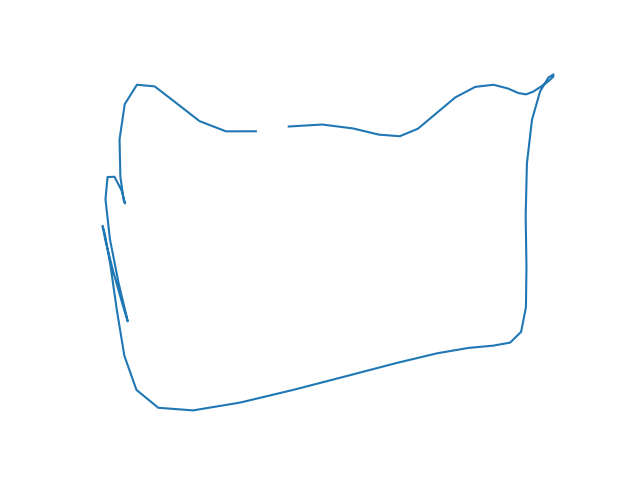

*   Output RNA:

  ```
Well  147
Card  481
File:  147 - 481.png
Image Category:  Golpe de bomba - Interferencia de gas
Top 5 confidence: 0.64427507 / 0.23681203 / 0.09778772 / 0.013982484 / 0.0071427287
Top 5 labels: Sin problemas / Golpe de bomba - Interferencia de gas / Golpe de bomba / Interferencia de gas / Problema no identificado
Percentage: 0.64427507
Diagnose: Sin problemas
Percentaje update: 64
```
*   Análisis:
  Si bien la imagen está catalogada por el experto con un diagnóstico de golpe de bomba e interferencia de gas, la RNA diagnostica a la carta como sin problemas. Si analizamos en mayor profundidad la carta, por la izquierda en el extremo inferior, no notamos una curva marcada de golpe de bomba por lo que es correcto su diagnóstico con respecto al golpe. En cuanto a la interferencia de gas, la curva que posee a la derecha es muy poco pronunciada por lo que se podría poner en duda si el pozo realmente está teniendo interferencia de gas o no. Cabe destacar que la RNA arroja un porcentaje de exactitud de 64% y es correcto este porcentaje debido a las conjeturas que hemos descrito.

## Licencia de Código
El código de la RNA está basado en fragmentos de código de la red neuronal artificial VGG desarrollada por Intel Corporation, brindadas las herramientas en una charla académica en la UTN FRBA en 2019.


---


Copyright (c) 2019 Intel Corporation.

Permission is hereby granted, free of charge, to any person obtaining
a copy of this software and associated documentation files (the
"Software"), to deal in the Software without restriction, including
without limitation the rights to use, copy, modify, merge, publish,
distribute, sublicense, and/or sell copies of the Software, and to
permit persons to whom the Software is furnished to do so, subject to
the following conditions:

The above copyright notice and this permission notice shall be
included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND,
EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF
MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND
NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE
LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION
OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION
WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.
